In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_data():
    DATADIR = "../input/ecg-sample/dataset/"
    samples = []
    annotations = []
    for i in range(0, 73):
        if i == 14:
            continue
        sample = DATADIR + "samples_" + str(i+1) + ".csv"
        annotation = DATADIR + "annotation_" + str(i+1) + ".csv"
        
        data_annot = pd.read_csv(annotation)
        annotations.append(data_annot.to_numpy())
        
        data = pd.read_csv(sample)  
        data = data.drop(0)
        data = data.reset_index()
        data = data.drop('index', axis =1)
        samples.append(data.to_numpy())
    
    return samples, annotations


In [3]:
samples, annotations = read_data()

In [4]:
len(samples), len(annotations), len(samples[0])

(72, 72, 15000)

In [6]:
def create_input_output(window_size, one_file_sample, one_file_annotation, sample_rate = 500):
    inputSeqs = []
    outputLabels = []
    len_one_signal = int(len(one_file_sample) / sample_rate)
    for signal in range(len_one_signal):
        input_signal = []
        output_signal = []
        for index in range(sample_rate - window_size + 1):
            input_ = []
            for i in range(window_size):
                input_.append(float(one_file_sample[signal + index + i][1]))
                if i != window_size-1:
                    input_.append(int(one_file_annotation[signal + index  + i]))
                else:
                    temp = [0, 0, 0, 0]
                    index = int(one_file_annotation[signal + index  + i])
                    temp[index] = 1
                    output = temp
            input_signal.append(input_)
            output_signal.append(output)
        inputSeqs.append(input_signal)
        outputLabels.append(output_signal)
    return inputSeqs, outputLabels

In [7]:
def train_test(window_size, samples, annotations):
    count_files = len(samples)
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in range(60):
        inputSeqs, outputLabels = create_input_output(window_size, samples[i], annotations[i])
        X_train.extend(inputSeqs)
        y_train.extend(outputLabels)
        
    for i in range(60, 72):
        inputSeqs, outputLabels = create_input_output(window_size, samples[i], annotations[i])
        X_test.extend(inputSeqs)
        y_test.extend(outputLabels)
        
    return X_train, y_train, X_test, y_test

In [77]:
class BI_LSTM_Net():
    def __init__(self, window_size, X_train, y_train, X_test, y_test):
        self.window_size = window_size
        
        self.dense_num = len(y_train[0])
        self.dense_unit = len(y_train[0][0])
        self.n_timesteps = len(X_train[0])
        self.features = len(X_train[0][0])
        print('dense', self.dense_unit)
        print('timestep', self.n_timesteps)
        print('features', self.features)
        
        self.X_train = np.array(X_train).reshape(len(X_train), self.n_timesteps, self.features)
        self.X_test = np.array(X_test).reshape(len(X_test), self.n_timesteps, self.features)
        
        self.y_train = np.array(y_train).reshape(len(y_train), self.dense_num, self.dense_unit)
        self.y_test = np.array(y_test).reshape(len(y_test), self.dense_num, self.dense_unit)
        
        print(self.X_train.shape, self.X_test.shape)
        print(self.y_train.shape, self.y_test.shape)
        
    def BI_LSTM_model(self, hidden_neurons, dense_neurons, dropout, dense_act, loss_func, optimizer_func):
        model = Sequential()
        model.add(Bidirectional(LSTM(hidden_neurons, return_sequences=True, recurrent_regularizer='l1', dropout=dropout), input_shape=(self.n_timesteps, self.features)))
        model.add(Dense(units=dense_neurons, activation=dense_act))
        model.compile(loss=loss_func, optimizer=optimizer_func, metrics=['acc']) 
        return model
    
    def train(self, epochs, batch_size, dropout, verbose):
        # optimizer = 'rmsprop', 'adam', RMSprop(0.001)
        # loss = 'binary_crossentropy', 'mean_squared_error'
        # loss = 'sparse_categorical_crossentropy', 'kullback_leibler_divergence', 'categorical_crossentropy'
        self.model = self.BI_LSTM_model(hidden_neurons=self.window_size,
                                         dense_neurons=self.dense_unit,
                                         dropout=dropout,
                                         dense_act='softmax',
                                         loss_func='kullback_leibler_divergence',
                                         optimizer_func=RMSprop(0.001)) 
                
        self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, validation_data=(self.X_test, self.y_test), verbose=verbose, shuffle=False)
        return self.model
    
    def predict(self):
        train_predict = self.model.predict(self.X_train)
        test_predict = self.model.predict(self.X_test)
        return train_predict, test_predict
    
    def evaluate(self):
        acc_train = self.model.evaluate(self.X_train, self.y_train)
        acc_test = self.model.evaluate(self.X_test, self.y_test)
        return acc_train[1], acc_test[1]

In [84]:
window_size = 5
X_train, y_train, X_test, y_test = train_test(window_size, samples, annotations)
bi_lstm = BI_LSTM_Net(window_size, X_train, y_train, X_test, y_test)
bi_lstm.train(epochs=200, batch_size=150, dropout= 0.1, verbose=1)
print(bi_lstm.model.summary())

dense 4
timestep 496
features 9
(1400, 496, 9) (60, 496, 9)
(1400, 496, 4) (60, 496, 4)
Epoch 1/200
10/10 [==============================] - 4s 129ms/step - loss: 1.7491 - acc: 0.2562 - val_loss: 1.8402 - val_acc: 0.1931
Epoch 2/200
10/10 [==============================] - 1s 57ms/step - loss: 1.6536 - acc: 0.3883 - val_loss: 1.7509 - val_acc: 0.2624
Epoch 3/200
10/10 [==============================] - 1s 57ms/step - loss: 1.5787 - acc: 0.5405 - val_loss: 1.6693 - val_acc: 0.2795
Epoch 4/200
10/10 [==============================] - 1s 57ms/step - loss: 1.5089 - acc: 0.6391 - val_loss: 1.5927 - val_acc: 0.3013
Epoch 5/200
10/10 [==============================] - 1s 57ms/step - loss: 1.4407 - acc: 0.6682 - val_loss: 1.5204 - val_acc: 0.4145
Epoch 6/200
10/10 [==============================] - 1s 57ms/step - loss: 1.3726 - acc: 0.6883 - val_loss: 1.4510 - val_acc: 0.4728
Epoch 7/200
10/10 [==============================] - 1s 57ms/step - loss: 1.3035 - acc: 0.7084 - val_loss: 1.3862 - val

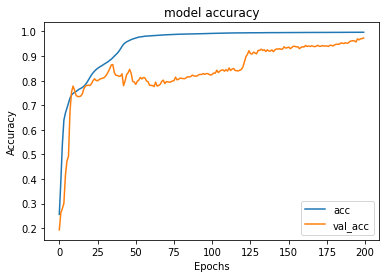

In [85]:
plt.plot(bi_lstm.model.history.history['acc'], label='acc')
plt.plot(bi_lstm.model.history.history["val_acc"], label="val_acc")
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

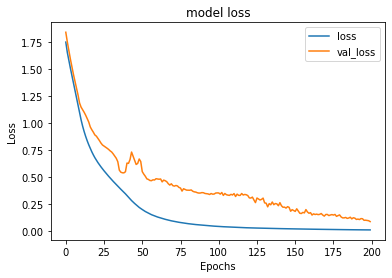

In [86]:
plt.plot(bi_lstm.model.history.history['loss'], label='loss')
plt.plot(bi_lstm.model.history.history["val_loss"], label="val_loss")
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [87]:
train_predict, test_predict = bi_lstm.predict()
acc_train, acc_test = bi_lstm.evaluate()

2/2 [==============================] - 0s 20ms/step - loss: 0.0915 - acc: 0.9737


In [88]:
print('Train accuracy: ', acc_train*100)
print('Test accuracy:  ', acc_test*100)

Train accuracy:  99.83798861503601
Test accuracy:   97.36559391021729


In [105]:
# pred = np.argmax(test_predict, axis=2)[0]
# test_predict.shape, len(pred), pred


In [104]:
# true_label = reverse_one_hot(y_test[0])
# np.array(true_label)

#### Window Size = 10

In [95]:
window_size = 10
X_train, y_train, X_test, y_test = train_test(window_size, samples, annotations)
bi_lstm_10 = BI_LSTM_Net(window_size, X_train, y_train, X_test, y_test)
bi_lstm_10.train(epochs=110, batch_size=150, dropout= 0.1, verbose=1)
print(bi_lstm_10.model.summary())

dense 4
timestep 491
features 19
(1400, 491, 19) (60, 491, 19)
(1400, 491, 4) (60, 491, 4)
Epoch 1/110
10/10 [==============================] - 4s 123ms/step - loss: 2.3466 - acc: 0.2677 - val_loss: 2.3655 - val_acc: 0.1755
Epoch 2/110
10/10 [==============================] - 1s 53ms/step - loss: 2.1424 - acc: 0.5979 - val_loss: 2.1670 - val_acc: 0.2676
Epoch 3/110
10/10 [==============================] - 1s 53ms/step - loss: 1.9875 - acc: 0.6921 - val_loss: 1.9408 - val_acc: 0.5410
Epoch 4/110
10/10 [==============================] - 1s 54ms/step - loss: 1.8425 - acc: 0.7069 - val_loss: 1.7945 - val_acc: 0.5453
Epoch 5/110
10/10 [==============================] - 1s 53ms/step - loss: 1.7059 - acc: 0.7159 - val_loss: 1.6792 - val_acc: 0.5318
Epoch 6/110
10/10 [==============================] - 1s 54ms/step - loss: 1.5780 - acc: 0.7239 - val_loss: 1.6156 - val_acc: 0.5255
Epoch 7/110
10/10 [==============================] - 1s 55ms/step - loss: 1.4573 - acc: 0.7350 - val_loss: 1.5708 - 

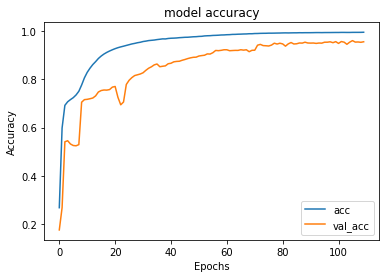

In [96]:
plt.plot(bi_lstm_10.model.history.history['acc'], label='acc')
plt.plot(bi_lstm_10.model.history.history["val_acc"], label="val_acc")
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

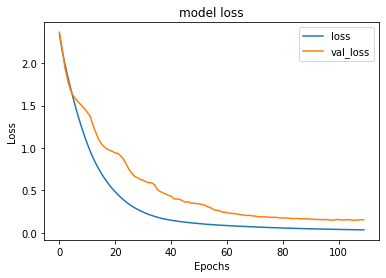

In [97]:
plt.plot(bi_lstm_10.model.history.history['loss'], label='loss')
plt.plot(bi_lstm_10.model.history.history["val_loss"], label="val_loss")
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [99]:
train_predict_10, test_predict_10 = bi_lstm_10.predict()
acc_train_10, acc_test_10 = bi_lstm_10.evaluate()
print('Train accuracy: ', acc_train*100)
print('Test accuracy:  ', acc_test*100)

2/2 [==============================] - 0s 24ms/step - loss: 0.1546 - acc: 0.9556
Train accuracy:  99.5843768119812
Test accuracy:   95.56347727775574


#### Window Size = 15

In [100]:
window_size = 15
X_train, y_train, X_test, y_test = train_test(window_size, samples, annotations)
bi_lstm_15 = BI_LSTM_Net(window_size, X_train, y_train, X_test, y_test)
bi_lstm_15.train(epochs=200, batch_size=150, dropout= 0.1, verbose=1)
print(bi_lstm_15.model.summary())

dense 4
timestep 486
features 29
(1400, 486, 29) (60, 486, 29)
(1400, 486, 4) (60, 486, 4)
Epoch 1/200
10/10 [==============================] - 4s 124ms/step - loss: 3.0454 - acc: 0.5198 - val_loss: 2.6863 - val_acc: 0.6217
Epoch 2/200
10/10 [==============================] - 1s 56ms/step - loss: 2.6423 - acc: 0.6643 - val_loss: 2.4576 - val_acc: 0.6693
Epoch 3/200
10/10 [==============================] - 1s 56ms/step - loss: 2.3626 - acc: 0.7090 - val_loss: 2.3763 - val_acc: 0.6730
Epoch 4/200
10/10 [==============================] - 1s 56ms/step - loss: 2.1244 - acc: 0.7493 - val_loss: 2.3160 - val_acc: 0.6755
Epoch 5/200
10/10 [==============================] - 1s 56ms/step - loss: 1.9110 - acc: 0.7904 - val_loss: 2.2608 - val_acc: 0.6785
Epoch 6/200
10/10 [==============================] - 1s 60ms/step - loss: 1.7178 - acc: 0.8255 - val_loss: 2.2080 - val_acc: 0.6817
Epoch 7/200
10/10 [==============================] - 1s 54ms/step - loss: 1.5443 - acc: 0.8445 - val_loss: 2.1681 - 

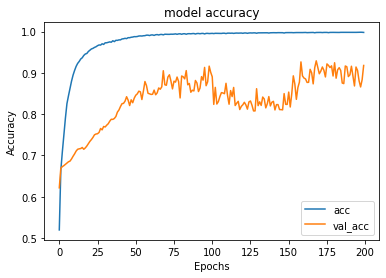

In [101]:
plt.plot(bi_lstm_15.model.history.history['acc'], label='acc')
plt.plot(bi_lstm_15.model.history.history["val_acc"], label="val_acc")
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

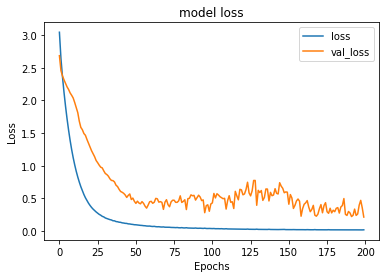

In [102]:
plt.plot(bi_lstm_15.model.history.history['loss'], label='loss')
plt.plot(bi_lstm_15.model.history.history["val_loss"], label="val_loss")
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [103]:
train_predict_15, test_predict_15 = bi_lstm_15.predict()
acc_train_15 acc_test_15 = bi_lstm_15.evaluate()
print('Train accuracy: ', acc_train*100)
print('Test accuracy:  ', acc_test*100)

2/2 [==============================] - 0s 24ms/step - loss: 0.2127 - acc: 0.9179
Train accuracy:  99.7592568397522
Test accuracy:   91.79012179374695
